In [1]:
import tensorflow as tf
from Arch import load_network
from utils import get_config_from_json
from Data import generate_tensordata, Dataset

2023-02-12 09:53:19.291010: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
epoch=9
n = epoch +1
power = -1/n
compression_ratio = 1000
sparsity = compression_ratio ** power
sparsity

0.5011872336272722

In [2]:
configs, _ = get_config_from_json('./config/VGG/config5.json')

initializerdic = {'varianceScaling': tf.initializers.variance_scaling(), 'HeNormal': tf.keras.initializers.HeNormal()}
batch_size = configs.batch_size
batch_size_for_prune = configs.batch_size_for_prune
datasource = configs.datasource
optimizer = configs.optimizer
lr_decay_type = configs.lr_decay_type
learning_rate = configs.learning_rate
boundaries = configs.boundaries
values = configs.values
train_iterations = configs.train_iterations
arch = configs.arch
initializer1= initializerdic[configs.initializer_conv]
initializer2= initializerdic[configs.initializer_dense]
#pruning_method = configs.pruning_method
batchtype = configs.batchtype
target_sparsity = configs.target_sparsity
prune_epoch = configs.pruning_epoch
experiment = configs.experiment


tensordata_train = generate_tensordata(datasource, 'train')
tensordata_val = generate_tensordata(datasource, 'val')
tensordata_test = generate_tensordata(datasource, 'test')

dat = Dataset(datasource)
num_classes = dat.num_classes

model = load_network(datasource, arch, num_classes, initializer1, initializer2)
weights = model.construct_weights(True)

2023-02-12 09:53:25.631358: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-12 09:53:25.632129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-12 09:53:25.658726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-02-12 09:53:25.658969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-02-12 09:53:25.658989: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-12 09:5

In [5]:
final_weight = weights
weightkeys = []
for key in final_weight.keys():
    weightkeys.append(key)
final_mask = {k:tf.Variable(tf.ones(final_weight[k].shape), trainable=False, dtype=tf.float32) for k in weightkeys}
vgg = model.make_layers(final_weight, final_mask)

In [ ]:
vgg.summary()

## GAN Pruning

In [1]:
import tensorflow as tf
import functools
from Data import preparebatch
import numpy as np

def apply_mask(weights, mask):
    all_keys = weights.keys()
    target_keys = mask.keys()
    remain_keys = list(set(all_keys) - set(target_keys))
    w_sparse = {k: mask[k] * weights[k] for k in target_keys}
    w_sparse.update({k: weights[k] for k in remain_keys})
    return w_sparse

def compute_loss(logits,flag):
    if flag == 'one':
       return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(logits), logits)
    elif flag == 'zero':
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(logits), logits)



2023-03-01 11:29:31.222003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
from ArchGan import load_network
with tf.device('/gpu:1'):
    target_sparsity = 0.9
    batch_size = 200
    batchtype = 'equal'
    datasource = 'mnist'
    arch = 'dcgan_mnist'
    latent_dim = 100
    initializer1 = tf.initializers.variance_scaling()
    initializer2 = tf.initializers.variance_scaling()
    model = load_network(datasource, arch, latent_dim, batch_size, initializer1, initializer2)
    weights_gen = model.construct_weights_gen(False)
    tf.random.set_seed(5)
    latent_dim = model.latentdim
    noise = tf.random.normal([batch_size, latent_dim])
    fake_images = model.forward_pass_gen(weights_gen, noise)

    weights_disc = model.construct_weights_disc(True)
    #discriminator = model.make_layers_disc(weights_disc)
    real_images,_ = preparebatch(model.datasource, batch_size, batchtype)

    prn_keys_disc = []
    for key in weights_disc.keys():
       prn_keys_disc.append(key)

    prn_keys_gen = []
    for key in weights_gen.keys():
       prn_keys_gen.append(key)

    mask_init_disc = {k:tf.Variable(tf.ones(weights_disc[k].shape), trainable=False, dtype=tf.float32) for k in prn_keys_disc}
    mask_init_gen = {k:tf.Variable(tf.ones(weights_gen[k].shape), trainable=False, dtype=tf.float32) for k in prn_keys_gen}

    discriminator = model.make_layers_disc(weights_disc, mask_init_disc)

    lr = 2e-4
    decay = 6e-8
    discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)

    with tf.GradientTape() as tape_disc:
        tape_disc.watch(mask_init_disc)
        w_mask_disc = apply_mask(weights_disc, mask_init_disc)
        logits_real = model.forward_pass_disc(w_mask_disc, real_images)
        logits_fake = model.forward_pass_disc(w_mask_disc, fake_images)
        real_loss = tf.reduce_mean(compute_loss(logits_real, flag='one'))
        fake_loss = tf.reduce_mean(compute_loss(logits_fake, flag='zero'))
        disc_loss = real_loss + fake_loss
    grads_disc = tape_disc.gradient( disc_loss ,[mask_init_disc[k] for k in prn_keys_disc])

    #discriminator_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_weights))
    with tf.GradientTape() as tape_gen:
        tape_gen.watch(mask_init_gen)
        w_mask_gen = apply_mask(weights_gen, mask_init_gen)
        generated_images = model.forward_pass_gen(w_mask_gen, noise)
        discriminator_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_weights))
        logits_gen = discriminator(generated_images, training=False)
        gen_loss = tf.reduce_mean(compute_loss(logits_gen, flag='one'))
    grads_gen = tape_gen.gradient(gen_loss, [mask_init_gen[k] for k in prn_keys_gen])


    gradients_disc = dict(zip(prn_keys_disc, grads_disc))

    gradients_abs_disc = {k: tf.abs(v) for k, v in gradients_disc.items()}
    grad_key_disc = gradients_abs_disc.keys()

    grad_shape_disc = {k: gradients_abs_disc[k].shape.as_list() for k in grad_key_disc}
    #grad_shape={'w1': [11, 11, 3, 96],'w2': [5, 5, 96, 256],'w3': [3, 3, 256, 384],'w4': [3, 3, 384, 384],'w5': [3, 3, 384, 256],'w6': [256, 1024],'w7': [1024, 1024],'w8': [1024, 10],
    #'b1': [96],'b2': [256],'b3': [384],'b4': [384],'b5': [256],'b6': [1024],'b7': [1024],'b8': [10]}
    split_sizes_disc = []
    for key in grad_key_disc:
       split_sizes_disc.append(functools.reduce(lambda x, y: x*y, grad_shape_disc[key]))   
    grad_v_disc = tf.concat([tf.reshape(gradients_abs_disc[k], [-1]) for k in grad_key_disc], axis=0) 
    normalgrad_v_disc = tf.divide(grad_v_disc, tf.reduce_sum(grad_v_disc))
    num_params_disc = normalgrad_v_disc.shape.as_list()[0]
    kappa_disc = int(round(num_params_disc * (1. - target_sparsity)))   
    topk_disc, ind_disc = tf.nn.top_k(normalgrad_v_disc, k=kappa_disc, sorted=True)
    sp_mask_disc = tf.SparseTensor(dense_shape=normalgrad_v_disc.shape.as_list(), values=tf.ones_like(ind_disc, dtype=tf.float32).numpy(), indices=np.expand_dims(ind_disc.numpy(), 1))
    mask_v_disc = tf.sparse.to_dense(sp_mask_disc, validate_indices=False)
    #restore mask_v as dictionary of weights
    v_splits_disc = tf.split(mask_v_disc, num_or_size_splits=split_sizes_disc)
    mask_restore_disc = {}
    for i, key in enumerate(grad_key_disc):
       mask_restore_disc.update({key: tf.reshape(v_splits_disc[i], grad_shape_disc[key])})
    final_mask_disc = mask_restore_disc
    final_w_disc = apply_mask(weights_disc, final_mask_disc)


    gradients_gen = dict(zip(prn_keys_gen, grads_gen))

    gradients_abs_gen = {k: tf.abs(v) for k, v in gradients_gen.items()}
    grad_key_gen = gradients_abs_gen.keys()

    grad_shape_gen = {k: gradients_abs_gen[k].shape.as_list() for k in grad_key_gen}
    #grad_shape={'w1': [11, 11, 3, 96],'w2': [5, 5, 96, 256],'w3': [3, 3, 256, 384],'w4': [3, 3, 384, 384],'w5': [3, 3, 384, 256],'w6': [256, 1024],'w7': [1024, 1024],'w8': [1024, 10],
    #'b1': [96],'b2': [256],'b3': [384],'b4': [384],'b5': [256],'b6': [1024],'b7': [1024],'b8': [10]}
    split_sizes_gen = []
    for key in grad_key_gen:
       split_sizes_gen.append(functools.reduce(lambda x, y: x*y, grad_shape_gen[key]))   
    grad_v_gen = tf.concat([tf.reshape(gradients_abs_gen[k], [-1]) for k in grad_key_gen], axis=0) 
    normalgrad_v_gen = tf.divide(grad_v_gen, tf.reduce_sum(grad_v_gen))
    num_params_gen = normalgrad_v_gen.shape.as_list()[0]
    kappa_gen = int(round(num_params_gen * (1. - target_sparsity)))   
    topk_gen, ind_gen = tf.nn.top_k(normalgrad_v_gen, k=kappa_gen, sorted=True)
    sp_mask_gen = tf.SparseTensor(dense_shape=normalgrad_v_gen.shape.as_list(), values=tf.ones_like(ind_gen, dtype=tf.float32).numpy(), indices=np.expand_dims(ind_gen.numpy(), 1))
    mask_v_gen = tf.sparse.to_dense(sp_mask_gen, validate_indices=False)
    #restore mask_v as dictionary of weights
    v_splits_gen = tf.split(mask_v_gen, num_or_size_splits=split_sizes_gen)
    mask_restore_gen = {}
    for i, key in enumerate(grad_key_gen):
       mask_restore_gen.update({key: tf.reshape(v_splits_gen[i], grad_shape_gen[key])})
    final_mask_gen = mask_restore_gen
    final_w_gen = apply_mask(weights_gen, final_mask_gen)


2023-03-01 11:41:23.532969: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-01 11:41:24.088411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


## train pruned GAN

In [5]:
with tf.device('/gpu:1'):
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images-127.5)/127.5
    BUFFER_SIZE = 60000
    BATCH_SIZE = 200
    # Batch and shuffle the data
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
discriminator = model.make_layers_disc(final_w_disc, mask_disc)
generator = model.make_layers_gen(final_w_gen, mask_gen)

In [ ]:
generator.summary()

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
lr = 2e-4
decay = 6e-8
generator_optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)

In [12]:
with tf.device('/gpu:1'):
    train_iteration=25000


    real_label = tf.ones(shape=(BATCH_SIZE,1))
    fake_label = tf.zeros(shape=(BATCH_SIZE,1))

    acc_metric_disc = tf.keras.metrics.BinaryCrossentropy(from_logits=True)
    acc_metric_gen = tf.keras.metrics.BinaryCrossentropy(from_logits=True)
    loss_avg_disc = tf.keras.metrics.Mean()
    loss_avg_gen = tf.keras.metrics.Mean()

    plot_loss_disc = []
    plot_acc_disc = []
    plot_loss_gen = []
    plot_acc_gen = []

    for itr in range(train_iteration):
        image_batch = next(iter(train_dataset))
        noise_dim = 100
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
            real_loss = cross_entropy(tf.ones_like(real_output), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
            disc_loss = real_loss + fake_loss
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)

        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_weights))
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))

        image_batch = tf.cast(image_batch, dtype=tf.dtypes.float32)
        generated_images = tf.cast(generated_images, dtype=tf.dtypes.float32)
        label = tf.concat((real_label, fake_label), axis=0)
        data = tf.concat((image_batch, generated_images), axis=0)
        logits_disc = discriminator(data, training=False)
        logits_gen = discriminator(generated_images, training=False)

        # Update training metric.
        acc_metric_disc.update_state(label, logits_disc)
        acc_metric_gen.update_state(real_label, logits_gen)
        loss_avg_disc.update_state(disc_loss)
        loss_avg_gen.update_state(gen_loss)
        if (itr + 1) % 100 == 0:
            acc_disc = acc_metric_disc.result()
            acc_gen = acc_metric_gen.result()

            loss_disc = loss_avg_disc.result()
            loss_gen = loss_avg_gen.result()

            plot_loss_disc.append(loss_disc)
            plot_loss_gen.append(loss_gen)

            plot_acc_disc.append(acc_disc)
            plot_acc_gen.append(acc_gen)
            
            print('train acc discriminator/generator acc at iteration %d: %.4f/%.4f ' % (itr+1, float(acc_disc), float(acc_gen)))
            #print("Training loss discriminator/generator at iteration %d: %.4f/ %.4f" % (itr+1, float(train_loss_disc), float(train_loss_gen)))
            acc_metric_disc.reset_states()
            acc_metric_gen.reset_states()

            loss_avg_disc.reset_states()
            loss_avg_gen.reset_states()

KeyboardInterrupt: 

In [26]:
from DCGAN_mnist2 import gan_2
with tf.device('/gpu:1'):
       final_weight_gen = gan_2()

train BinaryCrossentropyloss discriminator/generator acc at iteration 100: 0.4573/1.1361 
Training accuracy discriminator/generator at iteration 100: 0.8025/ 0.0387
train BinaryCrossentropyloss discriminator/generator acc at iteration 200: 0.6169/0.8863 
Training accuracy discriminator/generator at iteration 200: 0.6721/ 0.1004
train BinaryCrossentropyloss discriminator/generator acc at iteration 300: 0.6292/0.8967 
Training accuracy discriminator/generator at iteration 300: 0.6428/ 0.1264
train BinaryCrossentropyloss discriminator/generator acc at iteration 400: 0.6231/0.8670 
Training accuracy discriminator/generator at iteration 400: 0.6370/ 0.1471
train BinaryCrossentropyloss discriminator/generator acc at iteration 500: 0.6283/0.8075 
Training accuracy discriminator/generator at iteration 500: 0.6427/ 0.1367


In [ ]:
final_weight_gen

## retrieve saved weights

In [1]:
import h5py

def read_hdf5(path):

    weights = {}
    
    keys = []
     # open file
    with h5py.File(path, 'r') as f:
        f.visit(keys.append) # append all keys to list
        for key in keys:
            if ':' in key: # contains data if ':' in key
                print(f[key].name)
                weights[f[key].name] = f[key].value
    return weights

In [2]:
weights = read_hdf5('weight_test_gen.h5')

/batch_normalization_10/batch_normalization_10/beta:0
/batch_normalization_10/batch_normalization_10/gamma:0
/batch_normalization_10/batch_normalization_10/moving_mean:0
/batch_normalization_10/batch_normalization_10/moving_variance:0
/batch_normalization_11/batch_normalization_11/beta:0
/batch_normalization_11/batch_normalization_11/gamma:0
/batch_normalization_11/batch_normalization_11/moving_mean:0
/batch_normalization_11/batch_normalization_11/moving_variance:0
/batch_normalization_8/batch_normalization_8/beta:0
/batch_normalization_8/batch_normalization_8/gamma:0
/batch_normalization_8/batch_normalization_8/moving_mean:0
/batch_normalization_8/batch_normalization_8/moving_variance:0
/batch_normalization_9/batch_normalization_9/beta:0
/batch_normalization_9/batch_normalization_9/gamma:0
/batch_normalization_9/batch_normalization_9/moving_mean:0
/batch_normalization_9/batch_normalization_9/moving_variance:0
/conv_two_transpose/w2_Dconv_gen:0
/conv_two_transpose/w2_mask_gen:0
/conv_t

/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [ ]:
weights['/conv_two_transpose/w2_Dconv_gen:0']

In [ ]:
weights['/conv_two_10/w11_mask:0']

In [8]:
keylist = []
for key in weights.keys():
    if 'conv' in key or 'dense' in key:
        keylist.append(key)


In [9]:
keylist

['/conv_two/b1:0',
 '/conv_two/w1:0',
 '/conv_two_1/b2:0',
 '/conv_two_1/w2:0',
 '/conv_two_10/b11:0',
 '/conv_two_10/w11:0',
 '/conv_two_11/b12:0',
 '/conv_two_11/w12:0',
 '/conv_two_12/b13:0',
 '/conv_two_12/w13:0',
 '/conv_two_2/b3:0',
 '/conv_two_2/w3:0',
 '/conv_two_3/b4:0',
 '/conv_two_3/w4:0',
 '/conv_two_4/b5:0',
 '/conv_two_4/w5:0',
 '/conv_two_5/b6:0',
 '/conv_two_5/w6:0',
 '/conv_two_6/b7:0',
 '/conv_two_6/w7:0',
 '/conv_two_7/b8:0',
 '/conv_two_7/w8:0',
 '/conv_two_8/b9:0',
 '/conv_two_8/w9:0',
 '/conv_two_9/b10:0',
 '/conv_two_9/w10:0',
 '/dense/b14:0',
 '/dense/fc14:0']

In [32]:
weights = {}
keys = []
# open file
with h5py.File(path, 'r') as f:
    f.visit(keys.append) # append all keys to list
    for key in keys:
        if ':' in key: # contains data if ':' in key
            a = f[key].value
            n_zeros = np.count_nonzero(a==0)
            print(n_zeros, f[key].name)

0 /batch_normalization_10/batch_normalization_10/beta:0
0 /batch_normalization_10/batch_normalization_10/gamma:0
0 /batch_normalization_10/batch_normalization_10/moving_mean:0
0 /batch_normalization_10/batch_normalization_10/moving_variance:0
0 /batch_normalization_11/batch_normalization_11/beta:0
0 /batch_normalization_11/batch_normalization_11/gamma:0
0 /batch_normalization_11/batch_normalization_11/moving_mean:0
0 /batch_normalization_11/batch_normalization_11/moving_variance:0
5321 /batch_normalization_8/batch_normalization_8/beta:0
0 /batch_normalization_8/batch_normalization_8/gamma:0
5321 /batch_normalization_8/batch_normalization_8/moving_mean:0
0 /batch_normalization_8/batch_normalization_8/moving_variance:0
0 /batch_normalization_9/batch_normalization_9/beta:0
0 /batch_normalization_9/batch_normalization_9/gamma:0
0 /batch_normalization_9/batch_normalization_9/moving_mean:0
0 /batch_normalization_9/batch_normalization_9/moving_variance:0
0 /conv_two_transpose/Variable:0
0 /co

/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [1]:
import h5py
path = 'weights_test.h5'
keys = []
with h5py.File(path, 'r') as f: # open file
    f.visit(keys.append) # append all keys to list

In [2]:
keys

['batch_normalization_13',
 'batch_normalization_13/batch_normalization_13',
 'batch_normalization_13/batch_normalization_13/beta:0',
 'batch_normalization_13/batch_normalization_13/gamma:0',
 'batch_normalization_13/batch_normalization_13/moving_mean:0',
 'batch_normalization_13/batch_normalization_13/moving_variance:0',
 'batch_normalization_14',
 'batch_normalization_14/batch_normalization_14',
 'batch_normalization_14/batch_normalization_14/beta:0',
 'batch_normalization_14/batch_normalization_14/gamma:0',
 'batch_normalization_14/batch_normalization_14/moving_mean:0',
 'batch_normalization_14/batch_normalization_14/moving_variance:0',
 'batch_normalization_15',
 'batch_normalization_15/batch_normalization_15',
 'batch_normalization_15/batch_normalization_15/beta:0',
 'batch_normalization_15/batch_normalization_15/gamma:0',
 'batch_normalization_15/batch_normalization_15/moving_mean:0',
 'batch_normalization_15/batch_normalization_15/moving_variance:0',
 'batch_normalization_16',
 

In [3]:
with h5py.File(path, 'r') as f:
    a = f['conv_two/Variable:0'].value
type(a), a.shape

/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


(numpy.ndarray, (3, 3, 3, 64))

In [9]:
import numpy as np
n_zeros = np.count_nonzero(a==0)
n_zeros

0

## generate data with saved model

In [1]:
import tensorflow as tf
generator = tf.keras.models.load_model('mnistgenerator_pruned_test')

2023-01-30 18:25:40.452767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-30 18:25:41.370374: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-30 18:25:41.371226: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-30 18:25:41.403175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-30 18:25:41.403568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-30 18:2

In [2]:
# generate 60000 images
with tf.device('/gpu:1'):
    batch = 200
    generated_images = None
    for i in range(300):
       tf.random.set_seed(i)
       noise = tf.random.normal([batch, 100])
       generated_image = generator(noise)
       if generated_images is None:
          generated_images = generated_image
       else:
          generated_images = tf.concat([generated_images, generated_image], axis=0)

2023-01-30 18:25:55.739434: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-30 18:25:55.759918: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-01-30 18:25:55.769236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-30 18:25:55.974363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


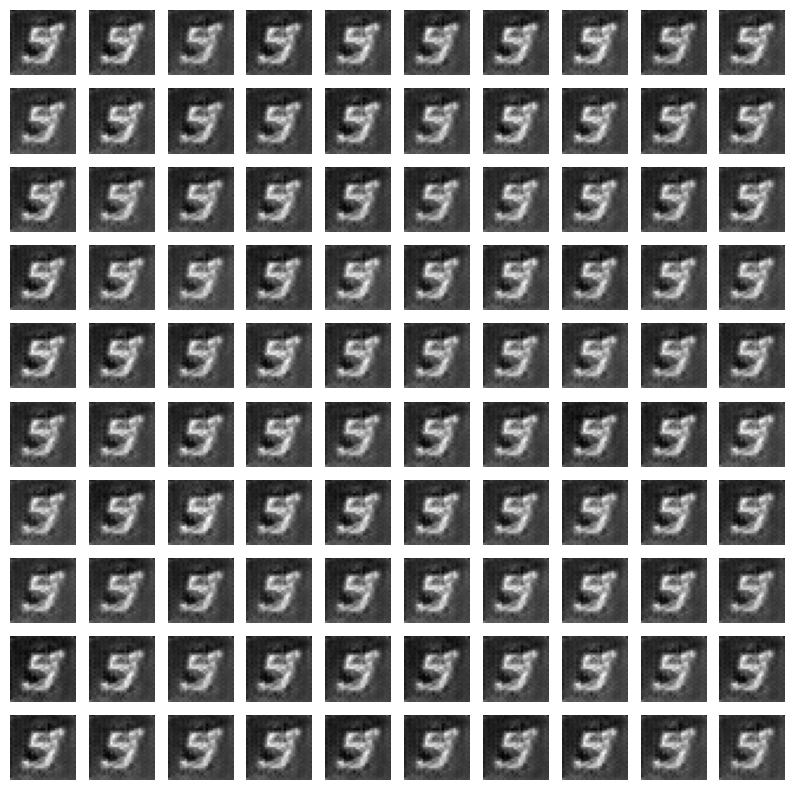

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_images[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

## read dataframe

In [6]:
import pandas as pd
df = pd.read_pickle('experimentResults.pkl')
df

,experiment,model,dataset,pruning_method,sparsity,test_accuracy,number_of_iterations
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.drop(list(range(1,32)), inplace=True)

In [4]:
df.head(10)

,experiment,model,dataset,pruning_method,sparsity,test_accuracy,number_of_iterations
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.to_pickle('experimentResults.pkl')


## Visualize Sparsities

In [4]:
from compute import visual_sparsity_layer
from utils import get_config_from_json
configs, _ = get_config_from_json('./config/VGG/config5.json')


2023-01-13 14:51:35.037831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


iteration 0


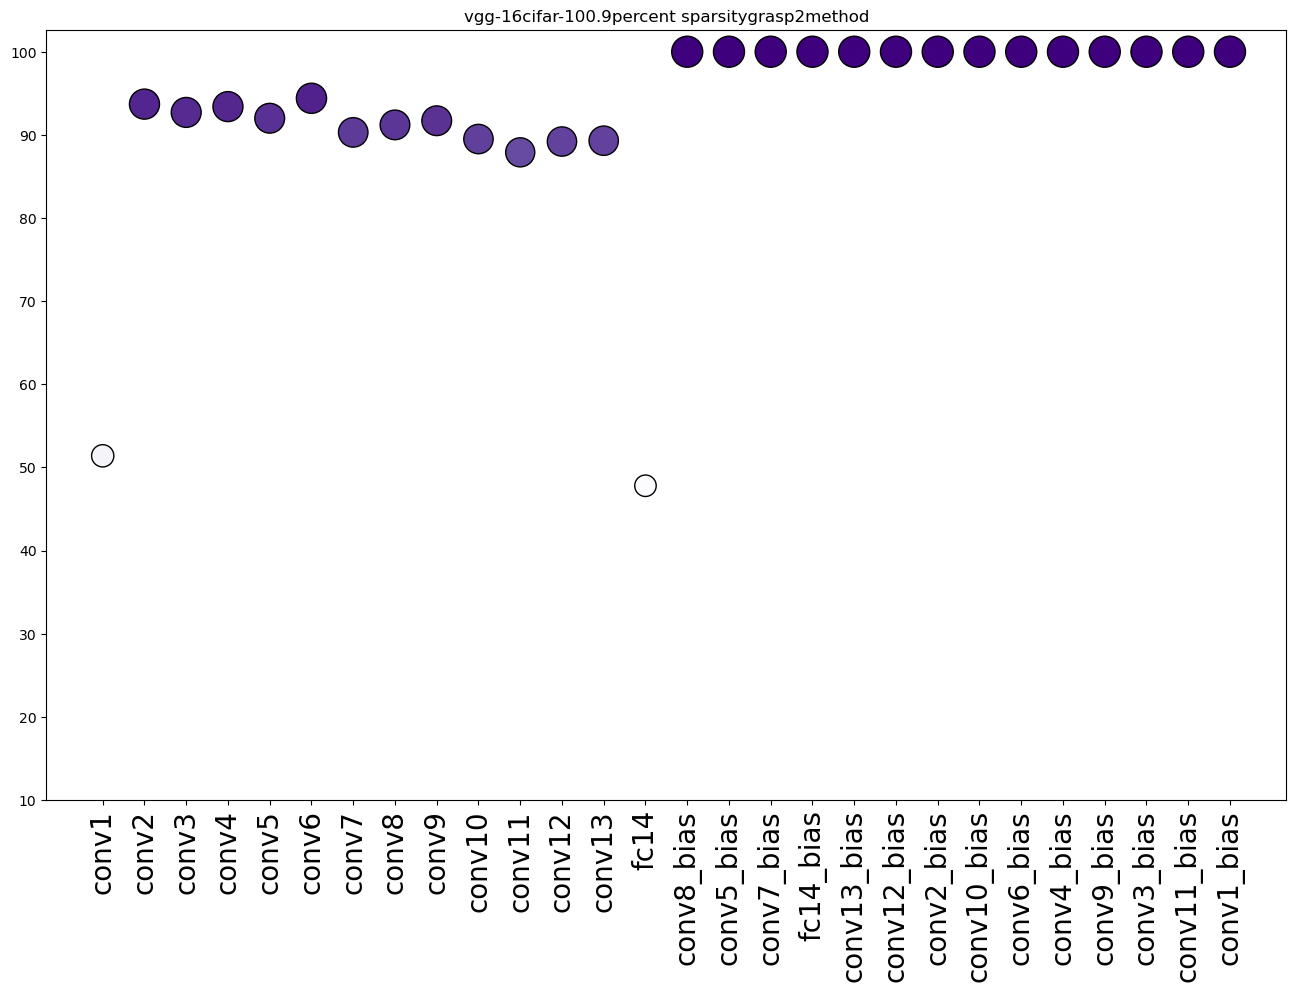

<Figure size 640x480 with 0 Axes>

In [3]:
visual_sparsity_layer(configs, 'grasp2')

iteration 0


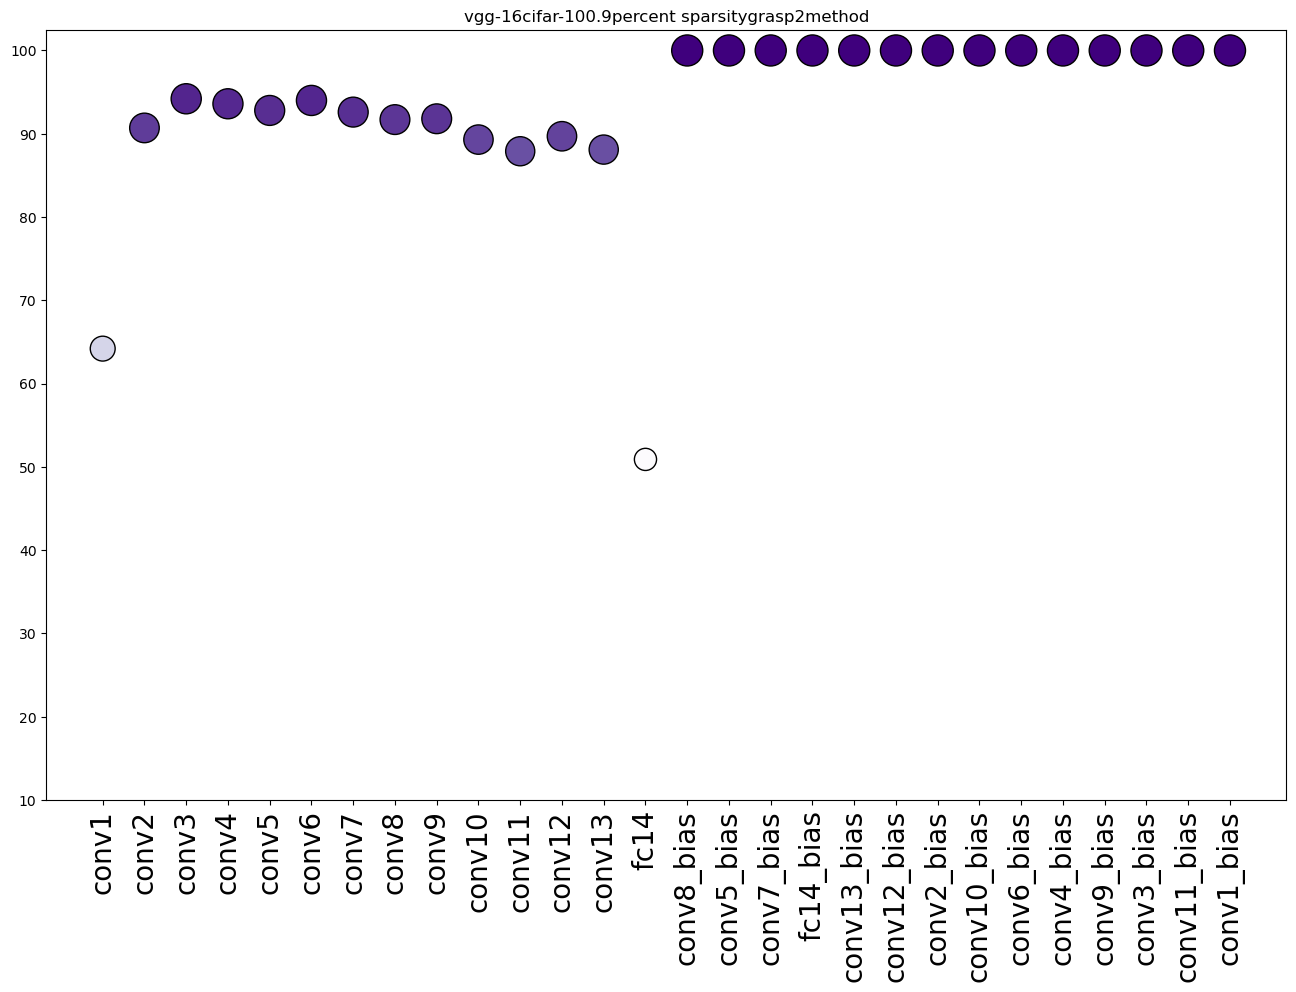

<Figure size 640x480 with 0 Axes>

In [4]:
visual_sparsity_layer(configs, 'grasp2')

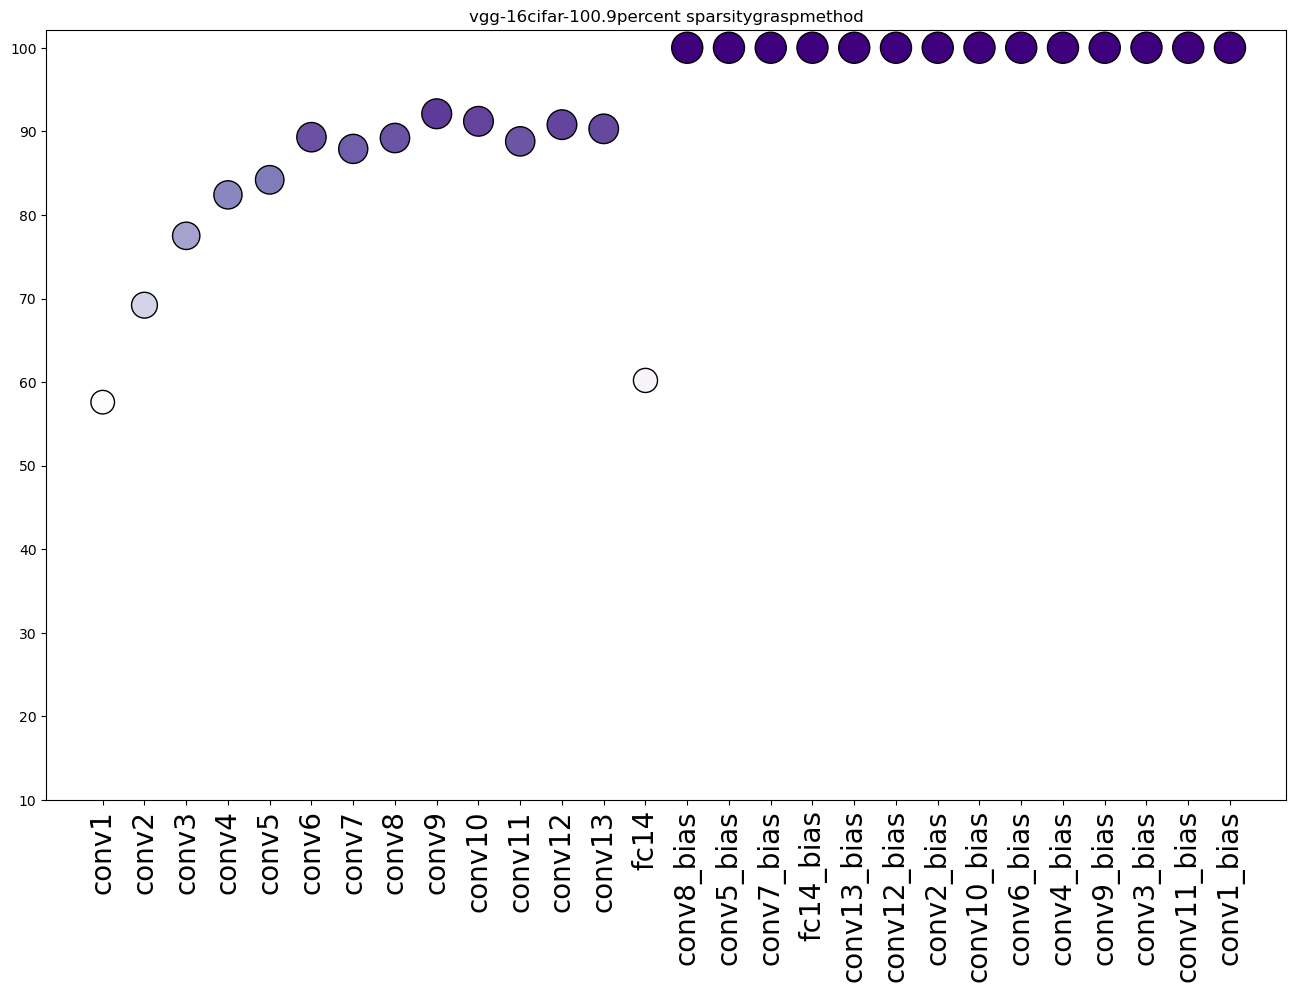

<Figure size 640x480 with 0 Axes>

In [5]:
visual_sparsity_layer(configs, 'grasp')

In [13]:
import pandas as pd
df = pd.read_csv('result.csv')
list_row = ['without', 0.9, 86.02, 1000]
df.loc[len(df)] = list_row
df.to_csv('result.csv')

In [14]:
df.head()

,pruning_method,sparsity,test_accuracy,number_of_iterations
0,without,0.9,86.02,1000


In [17]:
df.drop(0, inplace=True)

In [18]:
df

,pruning_method,sparsity,test_accuracy,number_of_iterations


In [8]:
from SynFlow import SynFlow
from utils import get_config_from_json
import tensorflow as tf 
from Data import generate_tensordata, Dataset
from Arch import load_network
configs, _ = get_config_from_json('./config/VGG/config1.json')
initializerdic = {'varianceScaling': tf.initializers.variance_scaling(), 'HeNormal': tf.keras.initializers.HeNormal(),
                       'zero': tf.keras.initializers.Zeros() , 'randomnormal':  tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05),
                       'randomuniform': tf.keras.initializers.RandomUniform(minval=0., maxval=1.), 'glorotnormal': tf.keras.initializers.GlorotNormal()}
batch_size = configs.batch_size
batch_size_for_prune = configs.batch_size_for_prune
datasource = configs.datasource
optimizer = configs.optimizer
lr_decay_type = configs.lr_decay_type
learning_rate = configs.learning_rate
boundaries = configs.boundaries
values = configs.values
train_iterations = configs.train_iterations
arch = configs.arch
initializer1= initializerdic[configs.initializer_conv]
initializer2= initializerdic[configs.initializer_dense]

batchtype = configs.batchtype
target_sparsity = configs.target_sparsity
prune_epoch = configs.pruning_epoch
experiment = configs.experiment


tensordata_train = generate_tensordata(datasource, 'train')
tensordata_val = generate_tensordata(datasource, 'val')
tensordata_test = generate_tensordata(datasource, 'test')

dat = Dataset(datasource)
num_classes = dat.num_classes

model = load_network(datasource, arch, num_classes, initializer1, initializer2)
weights = model.construct_weights(True)


In [15]:
import copy
def score(model, tensordata, weights):
   datasource = model.datasource
   inp, _ = next(iter(tensordata.batch(1)))
   input_one = tf.ones(inp.shape)
   weights_copy = copy.deepcopy(weights)
   #prn_keys = weights_copy.keys()
   all_keys = weights_copy.keys()
   prn_keys = []
   for key in weights_copy.keys():
      if tf.math.count_nonzero(weights_copy[key]).numpy() != 0:
         prn_keys.append(key)
   weights_abs = {k:tf.abs(weights_copy[k]) for k in all_keys}
   with tf.GradientTape() as tape:
      tape.watch(weights_copy)
      weights_abs = {k:tf.abs(weights_copy[k]) for k in all_keys}
      logits = model.forward_pass(weights_abs, input_one)
      loss = tf.reduce_sum(logits)
   grads = tape.gradient(loss, [weights_copy[k] for k in prn_keys])    #or weights_abs???
   gradients = dict(zip(prn_keys, grads))
   scores = {}
   for k in prn_keys:
      scores[k] = tf.abs(weights[k] * gradients[k])
   return scores


In [16]:
tensordata = tensordata_train
final_weights = copy.deepcopy(weights)
#compute score
S = score(model, tensordata, final_weights)



In [ ]:
tensordata = tensordata_train
final_weights = copy.deepcopy(weights)
   epochs = prune_epoch
   for epoch in range(epochs):
       S = score(model, tensordata, final_weights)
       S_shape = {k:S[k].shape.as_list() for k in S.keys()}
       split_sizes = []
       for k in S.keys():
          split_sizes.append(functools.reduce(lambda x,y: x*y, S_shape[k]))
       S_v = tf.concat([tf.reshape(S[k], [-1]) for k in S.keys()], axis=0)
       num_params = S_v.shape.as_list()[0]
       #sparsity = 0.5 + (0.1 * epoch)
       n = epoch +1
       power = -1/n
       compression_ratio = 1000
       sparsity = compression_ratio ** power
       kappa = int(round(num_params * (1- sparsity)))
       topk, ind = tf.nn.top_k(S_v, k=kappa, sorted=True)
       sp_mask = tf.SparseTensor(dense_shape=S_v.shape.as_list(), values=tf.ones_like(ind, dtype=tf.float32).numpy(), indices=np.expand_dims(ind.numpy(), 1))
       mask_v = tf.sparse.to_dense(sp_mask, validate_indices=False)
       v_splits = tf.split(mask_v, num_or_size_splits=split_sizes)
       mask_restore = {}
       for i, key in enumerate(S.keys()):
          mask_restore.update({key: tf.reshape(v_splits[i], S_shape[key])})
       final_mask = mask_restore
       final_weights = apply_mask(final_weights, final_mask)
   #set the weights of mask the same as weights
   all_keys = final_weights.keys()
   mask_keys = final_mask.keys()
   remain_keys = list(set(all_keys) - set(mask_keys))
   final_mask.update({k: tf.ones(shape=final_weights[k].shape) for k in remain_keys})
   return final_mask, final_weights

In [2]:
final_mask, final_weight = SynFlow(model, tensordata_train, weights, prune_epoch)

2023-05-05 09:08:51.686443: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-05 09:08:51.703172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-05-05 09:08:51.737859: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-05 09:08:52.814561: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [41]:
epochs = 100
epoch = 0
n = epochs
k = epoch + 1
power = -k/n
compression_ratio = 10
sparsity = compression_ratio ** power

In [42]:
sparsity

0.9772372209558107

: 